<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_6_sarcasm_with_1D_convolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a Sarcasm Detection Model using a Convolution Layer

You will be doing the same steps here as the previous lab but will be using a convolution layer instead. As usual, try tweaking the parameters and observe how it affects the results. 


In [1]:
# Install this package to use Colab's GPU for training
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

## Download the Dataset

In [2]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2022-09-09 21:06:14--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 74.125.133.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json.2’

sarcasm.json.2      100%[===================>]   5.38M  4.04MB/s    in 1.3s    

2022-09-09 21:06:16 (4.04 MB/s) - ‘sarcasm.json.2’ saved [5643545/5643545]



In [3]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [4]:
for i in range(1, 5):
    print(sentences[i], labels[i])

the 'roseanne' revival catches up to our thorny political mood, for better and worse 0
mom starting to fear son's web series closest thing she will have to grandchild 1
boehner just wants wife to listen, not come up with alternative debt-reduction ideas 1
j.k. rowling wishes snape happy birthday in the most magical way 0


## Split the Dataset

In [5]:
training_size = 20000

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

## Data preprocessing

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

2022-09-09 21:06:17.160114: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-09 21:06:17.165390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 21:06:17.165404: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Build and Compile the Model

In [7]:
import tensorflow as tf

# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
__________________________________________________

2022-09-09 21:06:20.536462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 21:06:20.536488: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 21:06:20.536506: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lscr): /proc/driver/nvidia/version does not exist
2022-09-09 21:06:20.536922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the Model

In [8]:
NUM_EPOCHS = 10

# Train the model
history_conv = model_conv.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4380 - accuracy: 0.7842 - val_loss: 0.3546 - val_accuracy: 0.8475
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2183 - accuracy: 0.9144 - val_loss: 0.3667 - val_accuracy: 0.8501
Epoch 3/10
625/625 [==============================] - 5s 7ms/step - loss: 0.1053 - accuracy: 0.9643 - val_loss: 0.4512 - val_accuracy: 0.8414
Epoch 4/10
625/625 [==============================] - 5s 7ms/step - loss: 0.0440 - accuracy: 0.9873 - val_loss: 0.5939 - val_accuracy: 0.8387
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.0162 - accuracy: 0.9958 - val_loss: 0.7053 - val_accuracy: 0.8301
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.8304 - val_accuracy: 0.8317
Epoch 7/10
625/625 [==============================] - 5s 8ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.9122 - val_accuracy: 0.8323
Epoch 

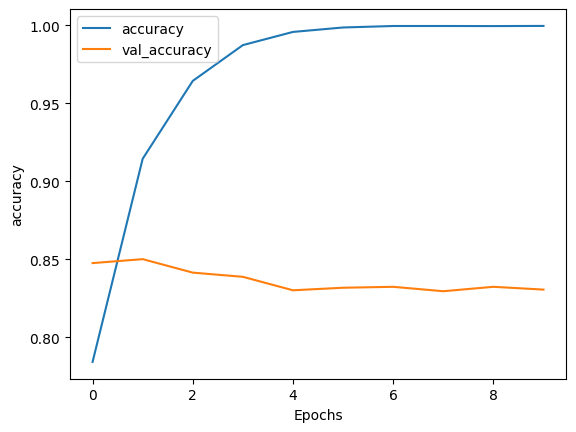

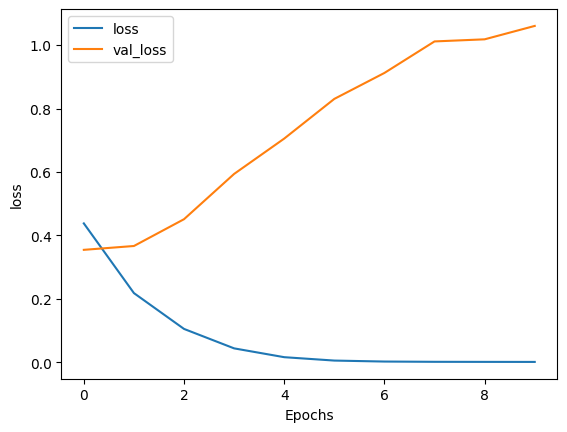

In [9]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')

In [10]:
# Predict

predict_string = ['I really really love my mother, but she shits me to tears and thinks I will die alone', 
                  'The only thing that I will have is a foot in the grave', 
                  'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
                 "i don't want you to solve my problems, i want you to listen to me",
                 "I’m not saying I hate you, what I’m saying is that you are literally the Monday of my life.",
                  "I am busy right now, can I ignore you some other time?",
                  "It’s okay if you don’t like me. Not everyone has good taste.",
                  "If you find me offensive. Then I suggest you quit finding me.",
                 ]

predict_sequences = tokenizer.texts_to_sequences(predict_string)
predict_padded = pad_sequences(predict_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predicted = model_conv.predict(predict_padded)

for i, prob in enumerate(predicted):
    if prob > 0.5:
        print(f'{predict_string[i]} is sarcastic. prob = {prob[0]: .3f}')
    else:
        print(f'{predict_string[i]} is not sarcastic. prob = {prob[0]: .3f}')

1/1 [==============================] - 0s 110ms/step
I really really love my mother, but she shits me to tears and thinks I will die alone is not sarcastic. prob =  0.000
The only thing that I will have is a foot in the grave is not sarcastic. prob =  0.000
boehner just wants wife to listen, not come up with alternative debt-reduction ideas is sarcastic. prob =  1.000
i don't want you to solve my problems, i want you to listen to me is not sarcastic. prob =  0.000
I’m not saying I hate you, what I’m saying is that you are literally the Monday of my life. is not sarcastic. prob =  0.000
I am busy right now, can I ignore you some other time? is sarcastic. prob =  1.000
It’s okay if you don’t like me. Not everyone has good taste. is sarcastic. prob =  1.000
If you find me offensive. Then I suggest you quit finding me. is not sarcastic. prob =  0.000


In [11]:
for 

SyntaxError: invalid syntax (1235331270.py, line 1)